In [1]:
import tensorflow as tf
import numpy as np
# import matplotlib as plt.
import matplotlib.pyplot as plt

import konlpy
import pandas as pd
from konlpy.tag import Mecab
from collections import Counter
print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


In [2]:
tokenizer = Mecab() #형태소분석기는 보통 전역변수처럼 사용한다.
#불용어 프로그램적으로 컨트롤하지 않을 계획으로 전역변수로 사용한다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '다']


In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [4]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data[train_data['document'].str.strip() != '']
    train_data = train_data[~train_data['document'].isin(stopwords) ]
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data[test_data['document'].str.strip() != '']
    test_data = test_data[~test_data['document'].isin(stopwords) ]
#     test_data = test_data[test_data['document'].str.strip() not in stopwords]
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
#         tagging = tokenizer.pos(sentence) # 형태소 분석
#         temp_X = [t[0] for t in tagging if ('V' in t[1] or 'N' in t[1]) and 'UNKNOWN' not in t[1] and len(t[0])>1] #형태소 분석 결과 중 명사/동사/형용사와 같은 의미있는 단어만 선택 
#         temp_X = [t[0] for t in tagging if 'UNKNOWN' not in t[1] and len(t[0])>1]
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        if len(temp_X) ==0 :
            print(sentence)
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
#         tagging = tokenizer.pos(sentence) # 형태소 분석
#         temp_X = [t[0] for t in tagging if ('V' in t[1] or 'N' in t[1]) and 'UNKNOWN' not in t[1] and len(t[0])>1] #형태소 분석 결과 중 명사/동사/형용사와 같은 의미있는 단어만 선택
#         temp_X = [t[0] for t in tagging if 'UNKNOWN' not in t[1] and len(t[0])>1]
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, {index:word for word, index in word_to_index.items()}

    
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

잘자
가자


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3.0* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.593177908834008
문장길이 최대 :  117
문장길이 최소 :  1
문장길이 표준편차 :  12.626668696164671
pad_sequences maxlen :  54
전체 문장의 0.9724423557357579%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = [row[-maxlen:] if len(row) > maxlen else row for row in X_train]
X_test = [row[-maxlen:] if len(row) > maxlen else row for row in X_test]
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.41249436867756
문장길이 최대 :  54
문장길이 최소 :  1
문장길이 표준편차 :  12.000770925940937


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [9]:
#중복코드 제거용
def modelFitTemp(model,X_train,y_train,epochs=20) :
    # validation set 분리
    x_val = X_train[:len(X_train)//7]   
    y_val = y_train[:len(X_train)//7]

    # validation set을 제외한 나머지 
    partial_x_train = X_train[len(X_train)//7:]  
    partial_y_train = y_train[len(X_train)//7:]
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1,
                       callbacks=callbacks)
    return history

In [10]:
#epochs에 따른 loss acc 시각화
def drawLossAccuracy(history) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
#     plt.figure(figsize=(20, 20))

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()   # 그림을 초기화합니다
#     plt.figure(figsize=(20, 20))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# drawLossAccuracy(history)

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
modelLSTM = tf.keras.Sequential()
modelLSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
modelLSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
modelLSTM.add(tf.keras.layers.Dense(256, activation='relu'))
modelLSTM.add(tf.keras.layers.Dropout(0.5))
modelLSTM.add(tf.keras.layers.Dense(64, activation='relu'))
modelLSTM.add(tf.keras.layers.Dropout(0.5))
modelLSTM.add(tf.keras.layers.Dense(16, activation='relu'))
modelLSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2166784   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1

In [12]:
history = modelFitTemp(modelLSTM,X_train,y_train,epochs=20)
print(modelLSTM.evaluate(X_test,  y_test, verbose=2))

Epoch 1/20
245/245 [==============================] - 39s 143ms/step - loss: 0.4964 - accuracy: 0.7609 - val_loss: 0.3535 - val_accuracy: 0.8472
Epoch 2/20
245/245 [==============================] - 33s 137ms/step - loss: 0.3448 - accuracy: 0.8571 - val_loss: 0.3518 - val_accuracy: 0.8481
Epoch 3/20
245/245 [==============================] - 33s 137ms/step - loss: 0.3246 - accuracy: 0.8659 - val_loss: 0.3474 - val_accuracy: 0.8509
Epoch 4/20
245/245 [==============================] - 34s 138ms/step - loss: 0.3070 - accuracy: 0.8731 - val_loss: 0.3510 - val_accuracy: 0.8505
Epoch 5/20
245/245 [==============================] - 34s 137ms/step - loss: 0.2897 - accuracy: 0.8795 - val_loss: 0.3498 - val_accuracy: 0.8503
Epoch 6/20
245/245 [==============================] - 34s 138ms/step - loss: 0.2697 - accuracy: 0.8873 - val_loss: 0.3650 - val_accuracy: 0.8546
1537/1537 - 10s - loss: 0.3563 - accuracy: 0.8461
[0.3563203811645508, 0.8460583686828613]


In [13]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for sentence in train_data['document']:
        f.write(str(sentence) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/ratings_train.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/ratings_train.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  

-rw-r--r-- 1 root root 374640 Jun 26 04:11 korean_spm.model
-rw-r--r-- 1 root root 144119 Jun 26 04:11 korean_spm.vocab


In [14]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가 방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가 방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1400, 10, 1704, 15, 1324, 10, 123, 17, 4]
['▁아버지', '가', '▁방', '에', '들어', '가', '신', '다', '.']
아버지가 방에들어가신다.


In [15]:
def load_data_spm(train_data, test_data, s):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data[train_data['document'].str.strip() != '']
    train_data = train_data[~train_data['document'].isin(stopwords) ]
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data[test_data['document'].str.strip() != '']
    test_data = test_data[~test_data['document'].isin(stopwords) ]
#     test_data = test_data[test_data['document'].str.strip() not in stopwords]
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = s.EncodeAsIds(sentence)  # 토큰화
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = s.EncodeAsIds(sentence)  # 토큰화
        X_test.append(temp_X)
    
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, index_word

    
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data_spm(train_data, test_data, s)

In [16]:
X_train = [row[-maxlen:] if len(row) > maxlen else row for row in X_train]
X_test = [row[-maxlen:] if len(row) > maxlen else row for row in X_test]
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.74659560961625
문장길이 최대 :  54
문장길이 최소 :  1
문장길이 표준편차 :  12.996970888774694


In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [18]:
vocab_size = 8000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
modelLSTM_SPM = tf.keras.Sequential()
modelLSTM_SPM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
modelLSTM_SPM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
modelLSTM_SPM.add(tf.keras.layers.Dense(256, activation='relu'))
modelLSTM_SPM.add(tf.keras.layers.Dropout(0.5))
modelLSTM_SPM.add(tf.keras.layers.Dense(64, activation='relu'))
modelLSTM_SPM.add(tf.keras.layers.Dropout(0.5))
modelLSTM_SPM.add(tf.keras.layers.Dense(16, activation='relu'))
modelLSTM_SPM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


modelLSTM_SPM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2166784   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [19]:
history_spm = modelFitTemp(modelLSTM_SPM,X_train,y_train,epochs=20)
print(modelLSTM_SPM.evaluate(X_test,  y_test, verbose=2))

Epoch 1/20
245/245 [==============================] - 38s 143ms/step - loss: 0.4792 - accuracy: 0.7525 - val_loss: 0.3590 - val_accuracy: 0.8406
Epoch 2/20
245/245 [==============================] - 34s 137ms/step - loss: 0.3409 - accuracy: 0.8571 - val_loss: 0.3481 - val_accuracy: 0.8495
Epoch 3/20
245/245 [==============================] - 34s 138ms/step - loss: 0.3162 - accuracy: 0.8679 - val_loss: 0.3355 - val_accuracy: 0.8554
Epoch 4/20
245/245 [==============================] - 34s 139ms/step - loss: 0.2980 - accuracy: 0.8759 - val_loss: 0.3409 - val_accuracy: 0.8533
Epoch 5/20
245/245 [==============================] - 34s 138ms/step - loss: 0.2789 - accuracy: 0.8837 - val_loss: 0.3411 - val_accuracy: 0.8535
Epoch 6/20
245/245 [==============================] - 34s 138ms/step - loss: 0.2591 - accuracy: 0.8907 - val_loss: 0.3511 - val_accuracy: 0.8547
1537/1537 - 10s - loss: 0.3471 - accuracy: 0.8488
[0.3471109867095947, 0.8488251566886902]


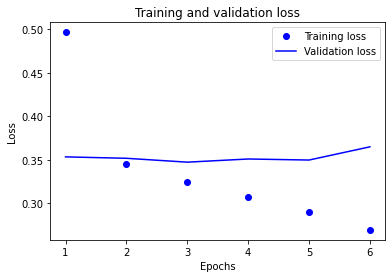

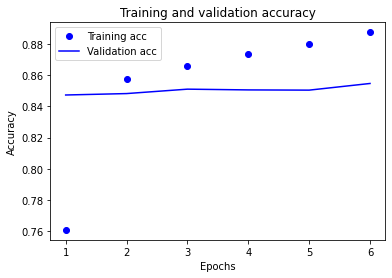

In [20]:
drawLossAccuracy(history)

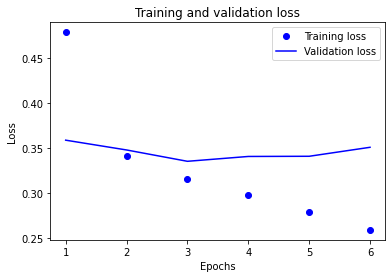

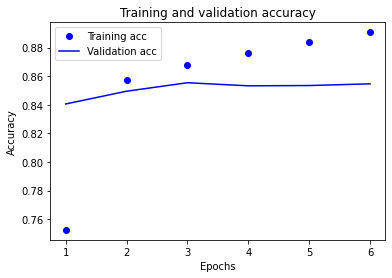

In [21]:
drawLossAccuracy(history_spm)